# American Express - Default Prediction  

<今回のデータ>  
submission : 924,621 rows  
train_labels : 458,914 rows   
df_train : 5,531,451 rows × 190 columns  
df_test : 11,363,762 rows

In [1]:
# あらゆるモデルをインポートしとく
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, plot_roc_curve, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

path = "C:/Users/Victor/Documents/my_study/Kaggle/Amex-Default-Prediction/"

# データサイズの削減

## testデータの処理

In [40]:
# customer_ID の列を別に保持（後で結合する）
test_customer_ID = pd.read_csv(path + 'test_data.csv', usecols=['customer_ID'])

In [3]:
# S_2(Date)列をdatetime型(datetime64[ns])に変換し別に保持
test_date = pd.read_csv(path + 'test_data.csv', usecols=['S_2'])
test_date['S_2'] = pd.to_datetime(test_date['S_2'])

# test_date's memory usage: 86.7+ MB -> 86.7 MB

In [4]:
# int型の列をint8に変換
column_int8 = ['B_30', 'B_31', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']
test_int8 = pd.read_csv(path + 'test_data.csv', usecols=column_int8)

# 変換の都合上nullを埋める
test_int8 = test_int8.fillna(99).astype('int8')

In [5]:
# 列を参照するための一時的なデータ
test_temp = pd.read_csv(path + 'test_data.csv', nrows=1000)
test_temp = test_temp.fillna(99)

In [6]:
# float64型の列を抽出
column_f64 = []
for i in list(test_temp.columns):
    if (test_temp[i].dtypes == 'float64') & (i not in column_int8):
        column_f64.append(i)

print('float64型の列数（全部：190）：', len(column_f64))

float64型の列数（全部：190）： 176


In [7]:
# float64の列を8分割し、それぞれ順番にfloat32に変換し結合
test_f32 = pd.DataFrame() # 空のデータフレーム
for i in range(8):
    test_f32_temp = pd.read_csv(path + 'test_data.csv', usecols=list(np.array_split(column_f64, 8)[i]))
    test_f32_temp = test_f32_temp.fillna(99).astype('float32')
    test_f32 = pd.concat([test_f32, test_f32_temp], axis=1)
    del test_f32_temp # メモリの確保

In [8]:
# 数値型以外の列の処理
column_obj = []
for i in list(test_temp.columns):
    if test_temp[i].dtypes == 'object':
        column_obj.append(i)
        
print('object型の列数（全部：190）：', len(column_obj))
print('列名：', column_obj)

object型の列数（全部：190）： 4
列名： ['customer_ID', 'S_2', 'D_63', 'D_64']


In [9]:
test_obj = pd.read_csv(path + 'test_data.csv', usecols=['D_63', 'D_64'])

In [10]:
# one-hot エンコーディング

print(test_obj['D_63'].value_counts(), '\n')
print(test_obj['D_64'].value_counts())

categ = ['D_63', 'D_64']
for i in categ:
    test_obj = pd.concat([test_obj, pd.get_dummies(test_obj[i], prefix=i, dummy_na=True)], sort=False, axis=1)
test_obj = test_obj.drop(categ, axis=1)

CO    8429213
CR    1830418
CL     917817
XZ     109754
XM      49717
XL      26843
Name: D_63, dtype: int64 

O    5993483
U    2952811
R    2039630
Name: D_64, dtype: int64


In [11]:
# 圧縮データの結合  # test_dateはとりまおいておく
test = pd.concat([test_int8, test_f32, test_obj], axis=1)

# メモリの確保
del test_int8
del test_f32
del test_obj

# トレーニングデータと合わせるため列を並び替え
test = test.reindex(columns=sorted(test.columns))

# 手前にID列を挿入
test = pd.concat([test_customer_ID, test], axis=1)

del test_customer_ID # メモリの確保

In [45]:
test

,customer_ID,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,B_19,B_2,B_20,B_21,B_22,B_23,B_24,B_25,B_26,B_27,B_28,B_29,B_3,B_30,B_31,B_32,B_33,B_36,B_37,B_38,B_39,B_4,B_40,B_41,B_42,B_5,B_6,B_7,B_8,B_9,D_102,D_103,D_104,D_105,D_106,D_107,D_108,D_109,D_110,D_111,D_112,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,D_130,D_131,D_132,D_133,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,D_50,D_51,D_52,D_53,D_54,D_55,D_56,D_58,D_59,D_60,D_61,D_62,D_63_CL,D_63_CO,D_63_CR,D_63_XL,D_63_XM,D_63_XZ,D_63_nan,D_64_O,D_64_R,D_64_U,D_64_nan,D_65,D_66,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_78,D_79,D_80,D_81,D_82,D_83,D_84,D_86,D_87,D_88,D_89,D_91,D_92,D_93,D_94,D_96,P_2,P_3,P_4,R_1,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_2,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_3,R_4,R_5,R_6,R_7,R_8,R_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_20,S_22,S_23,S_24,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.010728,-0.002919,0.004416,0.119198,99.000000,0.010182,0.010489,0.008663,99.0,0.592103,0.009144,0.814497,0.004986,0.009990,0.005210,1.134792,0.009799,0.006896,0.001656,0.004585,0.133804,99.000000,0.002347,0,1,0.002200,1.003810,0.008146,0.007970,1,99.0,0.116402,0.274203,0.009664,99.0,0.009517,0.174591,1.250677,1.003925,0.001013,0.002419,99.000000,99.000000,99.0,99.0,99.000000,99.000000,0.005124,99.0,99.0,1.004130,99.000000,99,99.000000,99,99,99.000000,99.000000,99,99.000000,99.000000,99.000000,99.000000,99.000000,0,0.006201,99.000000,99.000000,99.000000,99.000000,99.0,0.007082,99.0,99.0,99.0,99.0,99.0,99.000000,0.004669,99.000000,99.0,99.000000,0.008281,99.000000,0.001912,0.009971,0.113189,99.0,0.007584,0.004483,99.000000,0.474383,0.626467,99.0,99.0,0.008718,0.119043,99.0,1.005069,0.114564,99.0,0.205898,99.000000,0.027472,0.588734,0.051811,0,0,1,0,0,0,0,0,0,0,1,0.008294,99,99,99.000000,99.000000,0.014684,0.004310,0.178862,0.217694,0.204590,99.0,0.002916,0.004356,99.000000,0.000348,0.002291,0.508240,99.000000,0.009563,0.009909,99.0,99.0,0.006653,99.000000,0.008761,0.000835,0.004389,0.009575,0.631315,99.000000,0.959531,0.007547,0.001173,0.004170,1.002944,0.004322,0.008857,0.004144,0.006942,0.008908,0.002955,0.003418,0.005178,0.002948,0.004635,0.007474,0.000192,0.004115,0.008442,99.0,99.000000,0.005957,0.103590,0.002810,0.003420,0.002675,0.007748,0.002008,99.0,1.881856,0.190516,0.409411,0.400602,0.002531,0.005093,0.003684,0.008999,0.003781,0.981078,0.134916,0.954664,0.971086,0.006562,0.004302,0.168651,0.002771,1.006875,0.105587,0.321676,99.000000
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.011026,0.031222,0.010003,0.121490,0.028347,0.025130,0.021704,0.000835,99.0,0.590922,0.000165,0.810848,0.001557,0.008125,0.008394,0.208381,0.004549,0.003682,0.005516,0.009634,0.144626,99.000000,0.009132,0,1,0.006557,1.004629,0.000078,0.015463,1,99.0,0.134878,0.353639,0.007441,99.0,0.026313,0.177115,0.234169,1.009301,0.005533,0.006549,0.003031,0.008755,99.0,99.0,0.004698,99.000000,0.000610,99.0,99.0,1.004495,99.000000,99,99.000000,99,99,99.000000,99.000000,99,99.000000,99.000000,99.000000,99.000000,99.000000,0,0.003833,0.008782,0.005579,0.007598,0.008074,99.0,0.007188,99.0,99.0,99.0,99.0,99.0,0.000142,0.004940,0.009021,99.0,0.003695,0.003753,0.001460,0.005275,0.000166,0.123035,99.0,0.006646,0.009497,99.000000,0.473587,0.611682,99.0,99.0,0.003146,0.120991,99.0,1.000432,0.184116,99.0,0.403270,99.000000,0.054790,0.622886,0.057567,0,0,1,0,0,0,0,0,0,0,1,0.002011,99,99,99.000000,0.000606,0.011945,0.002283,0.179502,0.216526,0.206570,99.0,99.000000,0.001506,0.001013,0.003077,0.001225,0.508681,99.000000,0.002234,0.007458,99.0,99.0,0.004394,99.000000,0.004318,0.008072,0.007888,0.006952,0.587042,99.000000,0.961667,0.001817,0.005880,0.004056,1.003831,0.005300,0.001477,0.002083,0.005523,0.000843,0.007457,0.002382,0.009029,0.004449,0.000574,0.001169,0.006693,0.007656,0.006

In [44]:
# IDごとの集約データの生成
test_grouped = test.groupby(['customer_ID']).mean()
print(test_grouped.shape)
test_grouped.head()

(924621, 197)


,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,B_19,B_2,B_20,B_21,B_22,B_23,B_24,B_25,B_26,B_27,B_28,B_29,B_3,B_30,B_31,B_32,B_33,B_36,B_37,B_38,B_39,B_4,B_40,B_41,B_42,B_5,B_6,B_7,B_8,B_9,D_102,D_103,D_104,D_105,D_106,D_107,D_108,D_109,D_110,D_111,D_112,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,D_130,D_131,D_132,D_133,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,D_50,D_51,D_52,D_53,D_54,D_55,D_56,D_58,D_59,D_60,D_61,D_62,D_63_CL,D_63_CO,D_63_CR,D_63_XL,D_63_XM,D_63_XZ,D_63_nan,D_64_O,D_64_R,D_64_U,D_64_nan,D_65,D_66,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_78,D_79,D_80,D_81,D_82,D_83,D_84,D_86,D_87,D_88,D_89,D_91,D_92,D_93,D_94,D_96,P_2,P_3,P_4,R_1,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_2,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_3,R_4,R_5,R_6,R_7,R_8,R_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_20,S_22,S_23,S_24,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9
customer_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,0.013925,0.037069,0.006187,0.082867,11.048183,0.018828,0.020536,0.003792,99.000000,0.590665,0.004468,0.898289,0.005869,0.007769,0.004888,0.254266,0.005203,0.004567,0.005206,0.005720,0.145220,44.002163,0.009732,0.000000,1.0,0.005471,1.005949,0.004009,0.013483,1.777778,99.0,0.132557,0.368253,0.006821,99.0,0.047263,0.218059,0.283370,1.006641,0.003733,0.005494,11.003713,11.005265,99.000000,99.0,11.002491,99.0,0.004123,99.0,99.0,1.004091,44.003166,44.0,44.140057,44.0,43.444444,44.137173,44.137592,44.555556,44.109306,44.080723,44.002071,44.004681,44.003151,0.000000,0.005166,11.005355,11.005939,11.004889,11.004107,99.0,0.004254,99.0,99.0,99.0,99.0,99.0,11.003985,0.003996,11.005029,99.000000,11.004870,0.005730,11.004685,0.069758,0.002635,0.118016,77.001518,0.007083,0.011955,44.247833,0.479550,0.578279,99.0,99.000000,0.041620,0.117639,99.0,1.005194,0.317071,99.00000,0.377217,22.320761,0.042616,0.597552,0.035462,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.555556,0.444444,0.004591,99.0,47.333333,44.003464,11.003924,0.072740,0.004783,0.182713,0.219199,0.204130,99.0,88.000320,0.004126,11.004030,0.005002,0.004031,0.504131,44.002857,0.004711,0.007949,99.0,99.0,0.004934,77.000511,0.116208,0.004286,0.005423,0.004607,0.601387,44.328854,0.961646,0.005773,0.005161,0.005572,1.004421,0.004435,0.004547,0.003600,0.004303,0.004437,0.003736,0.003948,0.005000,0.004758,0.003851,0.004632,0.005964,0.006416,0.005308,99.000000,11.894776,0.005292,0.104659,0.005101,0.004464,0.003876,0.004423,0.006230,99.0,1.608184,0.136646,0.601419,0.459957,0.005912,0.005725,0.006010,0.006266,0.005406,0.962658,0.136015,0.949735,0.973917,0.038056,0.299671,0.188640,0.006742,0.227071,0.170330,0.271142,11.013840
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,0.052342,0.298050,0.035716,0.043231,0.099541,0.034238,0.004710,0.051158,99.000000,1.005336,0.004885,1.003704,0.004922,0.006818,0.004317,0.022771,0.005254,0.058109,0.002775,0.005269,0.033780,99.000000,0.006160,0.000000,1.0,0.003917,1.003672,0.005196,0.049217,2.230769,99.0,0.061213,0.025251,0.005565,99.0,0.101462,0.195901,0.033406,1.004206,0.081637,0.004841,0.003439,0.005631,99.000000,99.0,0.004473,99.0,0.005269,99.0,99.0,1.005064,0.003922,1.0,0.309216,0.0,3.000000,0.303904,0.303837,0.000000,0.842254,0.576952,0.003205,0.641199,0.004250,1.000000,0.006148,1.003930,0.004997,0.005076,0.004196,99.0,0.004032,99.0,99.0,99.0,99.0,99.0,0.006455,0.004865,0.004814,99.000000,0.005762,0.005329,0.005466,0.154252,0.003970,99.000000,99.000000,0.004452,0.088032,0.454435,0.351355,0.070145,99.0,99.000000,0.158422,0.148449,99.0,1.004121,0.063459,15.28512,0.005272,0.583729,0.507825,0.070053,0.328514,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000

## trainデータの処理

In [ ]:
# testデータと基本同じ処理　加工はなし

# customer_ID の列を別に保持（後で結合する）
train_customer_ID = pd.read_csv(path + 'train_data.csv', usecols=['customer_ID'])

# S_2(Date)列をdatetime型(datetime64[ns])に変換し別に保持
train_date = pd.read_csv(path + 'train_data.csv', usecols=['S_2'])
train_date['S_2'] = pd.to_datetime(train_date['S_2'])

# int型の列をint8に変換
column_int8 = ['B_30', 'B_31', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']
train_int8 = pd.read_csv(path + 'train_data.csv', usecols=column_int8)

# 変換の都合上nullを埋める
train_int8 = train_int8.fillna(99).astype('int8')

# 列を参照するための一時的なデータ
train_temp = pd.read_csv(path + 'train_data.csv', nrows=1000)
train_temp = train_temp.fillna(99)

# float64型の列を抽出
column_f64 = []
for i in list(train_temp.columns):
    if (train_temp[i].dtypes == 'float64') & (i not in column_int8):
        column_f64.append(i)
        
# float64の列を４分割し、それぞれ順番にfloat32に変換し結合
train_f32 = pd.DataFrame() # 空のデータフレーム
for i in range(8):
    train_f32_temp = pd.read_csv(path + 'train_data.csv', usecols=list(np.array_split(column_f64, 8)[i]))
    train_f32_temp = train_f32_temp.fillna(99).astype('float32')
    train_f32 = pd.concat([train_f32, train_f32_temp], axis=1)
    del train_f32_temp # メモリの確保
    
# 数値型以外の列の処理
column_obj = []
for i in list(train_temp.columns):
    if train_temp[i].dtypes == 'object':
        column_obj.append(i)
        
train_obj = pd.read_csv(path + 'train_data.csv', usecols=['D_63', 'D_64'])

# 圧縮データの結合
train = pd.concat([train_int8, train_f32, train_obj], axis=1)

# 合わせるため列を並び替え
train =train.reindex(columns=sorted(train.columns))

# 手前にID列を挿入
train = pd.concat([train_customer_ID, train_date, train], axis=1)

# メモリの確保
del train_date
del train_int8
del train_f32
del train_obj
del train_customer_ID 

In [ ]:
df = train
del train
print(df.shape)
df.head()

# trainデータの学習とモデル作成

In [47]:
# データの読み込み　なぜか nrows を設定すると全部読み込める...-> 読み込めなくなった

# df = pd.read_csv(path + 'train_data.csv', nrows=100000)
# df = pd.read_csv(path + 'train_data.csv')
df_train_labels = pd.read_csv(path + 'train_labels.csv')

## 簡単な前処理

In [116]:
# one-hot エンコーディング
# null列を作ってくれるから補完前に行う

print(df['D_63'].value_counts(), '\n')
print(df['D_64'].value_counts())

categ = ['D_63', 'D_64']
print(categ)

for i in categ:
    df = pd.concat([df, pd.get_dummies(df[i], prefix=i, dummy_na=True)], sort=False, axis=1)
df = df.drop(categ, axis=1)

CO    4119621
CR     930133
CL     438390
XZ      25786
XM      10556
XL       6965
Name: D_63, dtype: int64 

O     2913244
U     1523448
R      840112
-1      37205
Name: D_64, dtype: int64
['D_63', 'D_64']


In [117]:
# 今後の都合上形式的に欠損値を補完
# df = df.fillna(99)

# とりあえず日付データは落とす
df = df.drop('S_2', axis=1)

# testデータには D_64 = -1 のデータがないので落とす
df = df.drop('D_64_-1', axis=1)

In [118]:
print(df.shape)
df.head()

(5531451, 198)


,customer_ID,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,D_63_CL,D_63_CO,D_63_CR,D_63_XL,D_63_XM,D_63_XZ,D_63_nan,D_64_O,D_64_R,D_64_U,D_64_nan
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,99.0,99.0,0.000630,0.080986,0.708906,0.170600,0.006204,0.358587,0.525351,0.255736,99.0,0.063902,0.059416,0.006466,0.148698,1.335856,0.008207,0.001423,0.207334,0.736463,0.096219,99.0,0.023381,0.002768,0.008322,1.001519,0.008298,0.161345,0.148266,0.922998,0.354596,0.152025,0.118075,0.001882,0.158612,0.065728,0.018385,0.063646,0.199617,0.308233,0.016361,0.401619,0.091071,0.007126,0.007665,99.0,0.652984,0.008520,99.0,0.004730,6.0,0.272008,0.008363,0.515222,0.002644,0.009013,0.004808,0.008342,0.119403,0.004802,0.108271,0.050882,99.0,0.007554,0.080422,0.069067,99.0,0.004327,0.007562,99.0,0.007729,0.000272,0.001576,0.004239,0.001434,99.0,0.002271,0.004061,0.007121,0.002456,0.002310,0.003532,0.506612,0.008033,1.009825,0.084683,0.003820,0.007043,0.000438,0.006452,0.000830,0.005055,99.0,0.0,0.005720,0.007084,99.0,0.000198,0.008907,99.0,1,0.002537,0.005177,0.006626,0.009705,0.007782,0.002450,1.001101,0.002665,0.007479,0.006893,1.503673,1.006133,0.003569,0.008871,0.003950,0.003647,0.004950,0.894090,0.135561,0.911191,0.974539,0.001243,0.766688,1.008691,1.004587,0.893734,99.0,0.670041,0.009968,0.004572,99.0,1.008949,2.0,99.0,0.004326,99.0,99.0,99.0,1.007336,0.210060,0.676922,0.007871,1.0,0.238250,0.0,4.0,0.232120,0.236266,0.0,0.702280,0.434345,0.003057,0.686516,0.008740,1.0,1.003319,1.007819,1.000080,0.006805,99.0,0.002052,0.005972,99.0,0.004345,0.001535,99.0,99.0,99.0,99.0,99.0,0.002427,0.003706,0.003818,99.0,0.000569,0.000610,0.002674,0,0,1,0,0,0,0,1,0,0,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,99.0,99.0,0.002526,0.069419,0.712795,0.113239,0.006206,0.353630,0.521311,0.223329,99.0,0.065261,0.057744,0.001614,0.149723,1.339794,0.008373,0.001984,0.202778,0.720886,0.099804,99.0,0.030599,0.002749,0.002482,1.009033,0.005136,0.140951,0.143530,0.919414,0.326757,0.156201,0.118737,0.001610,0.148459,0.093935,0.013035,0.065501,0.151387,0.265026,0.017688,0.406326,0.086805,0.002413,0.007148,99.0,0.647093,0.002238,99.0,0.003879,6.0,0.188970,0.004030,0.509048,0.004193,0.007842,0.001283,0.006524,0.140611,0.000094,0.101018,0.040469,99.0,0.004832,0.081413,0.074166,99.0,0.004203,0.005304,99.0,0.001864,0.000979,0.009896,0.007597,0.000509,99.0,0.009810,0.000127,0.005966,0.000395,0.001327,0.007773,0.500855,0.000760,1.009461,0.081843,0.000347,0.007789,0.004311,0.002332,0.009469,0.003753,99.0,0.0,0.007584,0.006677,99.0,0.001142,0.005907,99.0,1,0.008427,0.008979,0.001854,0.009924,0.005987,0.002247,1.006779,0.002508,0.006827,0.002837,1.503577,1.005791,0.000571,0.000391,0.008351,0.008850,0.003180,0.902135,0.136333,0.919876,0.975624,0.004561,0.786007,1.000084,1.004118,0.906841,99.0,0.668647,0.003921,0.004654,99.0,1.003205,2.0,99.0,0.008707,99.0,99.0,99.0,1.007653,0.184093,0.822281,0.003444,1.0,0.247217,0.0,4.0,0.243532,0.241885,0.0,0.70

In [119]:
# とりあえず集約データで予測モデルをつくってみる
df2 = df.groupby(['customer_ID']).mean()
df2 = df2.reindex(columns=sorted(df2.columns))
print(df2.shape)
del df
df2.head()

(458913, 197)


,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,B_19,B_2,B_20,B_21,B_22,B_23,B_24,B_25,B_26,B_27,B_28,B_29,B_3,B_30,B_31,B_32,B_33,B_36,B_37,B_38,B_39,B_4,B_40,B_41,B_42,B_5,B_6,B_7,B_8,B_9,D_102,D_103,D_104,D_105,D_106,D_107,D_108,D_109,D_110,D_111,D_112,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,D_130,D_131,D_132,D_133,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,D_50,D_51,D_52,D_53,D_54,D_55,D_56,D_58,D_59,D_60,D_61,D_62,D_63_CL,D_63_CO,D_63_CR,D_63_XL,D_63_XM,D_63_XZ,D_63_nan,D_64_O,D_64_R,D_64_U,D_64_nan,D_65,D_66,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_78,D_79,D_80,D_81,D_82,D_83,D_84,D_86,D_87,D_88,D_89,D_91,D_92,D_93,D_94,D_96,P_2,P_3,P_4,R_1,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_2,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_3,R_4,R_5,R_6,R_7,R_8,R_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_20,S_22,S_23,S_24,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9
customer_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.012007,0.270280,0.007230,0.125683,0.100432,0.023142,0.026247,0.004769,99.000000,0.842565,0.005231,1.005086,0.005731,0.005500,0.005700,0.026177,0.005135,0.005915,0.004408,0.004098,0.050968,99.0,0.006456,0.0,1.0,0.005084,1.004033,0.005292,0.012015,2.000000,99.0,0.040309,0.087300,0.006753,99.0,0.146650,0.113510,0.036624,0.003585,0.006220,0.856909,1.005189,1.009606,0.984966,99.0,0.672166,99.0,0.006114,99.0,99.0,1.004348,0.005476,1.000000,0.247095,0.0,4.000000,0.245514,0.244733,0.000000,0.711829,0.433732,0.003103,0.686641,0.006253,1.0,1.006123,1.004154,1.005537,0.005195,0.005446,99.0,0.004760,99.0,99.0,99.0,99.0,99.0,0.003664,0.005343,0.005178,99.0,0.005066,0.005283,0.005814,0.010704,0.005021,99.0,99.000000,0.004673,0.725369,0.378074,0.532874,23.031521,99.0,0.150326,0.978914,0.204972,99.000000,1.006225,0.224432,0.158571,0.064803,0.061147,0.534817,15.421870,38.188484,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.004701,99.0,6.000000,0.005275,0.005221,0.214785,0.004495,99.0,0.039496,0.036125,99.0,83.833738,0.005218,0.004170,0.081974,0.005834,0.505637,0.004892,0.004945,0.004874,99.0,99.0,0.005235,1.197627,0.543890,0.004415,0.005909,0.003619,0.933824,0.680138,0.005670,0.004509,0.004742,0.004784,1.004889,0.004522,0.005879,0.005171,0.004740,0.004164,0.006589,0.005231,0.005754,0.005231,0.004931,0.005002,0.004593,0.005469,0.005799,99.0,1.005594,0.004089,0.004752,0.006656,0.004684,0.006067,0.005851,0.005595,99.0,0.469887,0.247988,0.654700,0.173335,0.004974,0.005079,0.005075,0.005955,0.006292,0.916144,0.135036,0.931956,0.974669,0.012560,0.850951,0.113215,0.029112,0.004647,0.098374,0.797145,0.039818
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.025654,0.298815,0.013792,0.025823,0.046753,0.014848,0.005560,0.076456,99.000000,1.004884,0.004915,0.991083,0.004935,0.005497,0.005374,0.013286,0.004736,0.024090,0.005267,0.004588,0.017052,99.0,0.005663,0.0,1.0,0.005960,1.005387,0.006088,0.025244,2.000000,99.0,0.016746,0.022125,0.005432,99.0,0.035462,0.202270,0.028049,0.004956,0.010298,0.004578,0.005606,0.004932,99.000000,99.0,0.005859,99.0,0.006870,99.0,99.0,1.006037,0.006391,1.000000,0.439431,0.0,-1.000000,0.433039,0.430961,0.384615,0.535892,0.290804,0.006022,0.140331,0.004236,1.0,0.080648,1.002631,0.004173,0.003449,0.004214,99.0,0.004519,99.0,99.0,99.0,99.0,99.0,0.004906,0.006271,0.006007,99.0,0.004824,0.004218,0.004902,0.215205,0.004993,99.0,45.770154,0.004311,0.256461,0.452041,0.392433,0.048203,99.0,99.000000,0.390638,0.158313,99.000000,1.006141,0.048069,0.705671,0.005146,0.232975,0.326530,0.053319,0.238520,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.004130,99.0,6.000000,0.005872,0.004143,0.011508,0.004690,99.0,0.005337,0.006471,99.0,0.2239

In [123]:
# targetをtrainデータと結合
df2 = pd.merge(df2, df_train_labels, on='customer_ID', how='left')
print(df2.shape)
df2.head()

(458913, 199)


,customer_ID,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,B_19,B_2,B_20,B_21,B_22,B_23,B_24,B_25,B_26,B_27,B_28,B_29,B_3,B_30,B_31,B_32,B_33,B_36,B_37,B_38,B_39,B_4,B_40,B_41,B_42,B_5,B_6,B_7,B_8,B_9,D_102,D_103,D_104,D_105,D_106,D_107,D_108,D_109,D_110,D_111,D_112,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,D_130,D_131,D_132,D_133,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,D_50,D_51,D_52,D_53,D_54,D_55,D_56,D_58,D_59,D_60,D_61,D_62,D_63_CL,D_63_CO,D_63_CR,D_63_XL,D_63_XM,D_63_XZ,D_63_nan,D_64_O,D_64_R,D_64_U,D_64_nan,D_65,D_66,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_78,D_79,D_80,D_81,D_82,D_83,D_84,D_86,D_87,D_88,D_89,D_91,D_92,D_93,D_94,D_96,P_2,P_3,P_4,R_1,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_2,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_3,R_4,R_5,R_6,R_7,R_8,R_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_20,S_22,S_23,S_24,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.012007,0.270280,0.007230,0.125683,0.100432,0.023142,0.026247,0.004769,99.000000,0.842565,0.005231,1.005086,0.005731,0.005500,0.005700,0.026177,0.005135,0.005915,0.004408,0.004098,0.050968,99.0,0.006456,0.0,1.0,0.005084,1.004033,0.005292,0.012015,2.000000,99.0,0.040309,0.087300,0.006753,99.0,0.146650,0.113510,0.036624,0.003585,0.006220,0.856909,1.005189,1.009606,0.984966,99.0,0.672166,99.0,0.006114,99.0,99.0,1.004348,0.005476,1.000000,0.247095,0.0,4.000000,0.245514,0.244733,0.000000,0.711829,0.433732,0.003103,0.686641,0.006253,1.0,1.006123,1.004154,1.005537,0.005195,0.005446,99.0,0.004760,99.0,99.0,99.0,99.0,99.0,0.003664,0.005343,0.005178,99.0,0.005066,0.005283,0.005814,0.010704,0.005021,99.0,99.000000,0.004673,0.725369,0.378074,0.532874,23.031521,99.0,0.150326,0.978914,0.204972,99.000000,1.006225,0.224432,0.158571,0.064803,0.061147,0.534817,15.421870,38.188484,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.004701,99.0,6.000000,0.005275,0.005221,0.214785,0.004495,99.0,0.039496,0.036125,99.0,83.833738,0.005218,0.004170,0.081974,0.005834,0.505637,0.004892,0.004945,0.004874,99.0,99.0,0.005235,1.197627,0.543890,0.004415,0.005909,0.003619,0.933824,0.680138,0.005670,0.004509,0.004742,0.004784,1.004889,0.004522,0.005879,0.005171,0.004740,0.004164,0.006589,0.005231,0.005754,0.005231,0.004931,0.005002,0.004593,0.005469,0.005799,99.0,1.005594,0.004089,0.004752,0.006656,0.004684,0.006067,0.005851,0.005595,99.0,0.469887,0.247988,0.654700,0.173335,0.004974,0.005079,0.005075,0.005955,0.006292,0.916144,0.135036,0.931956,0.974669,0.012560,0.850951,0.113215,0.029112,0.004647,0.098374,0.797145,0.039818,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.025654,0.298815,0.013792,0.025823,0.046753,0.014848,0.005560,0.076456,99.000000,1.004884,0.004915,0.991083,0.004935,0.005497,0.005374,0.013286,0.004736,0.024090,0.005267,0.004588,0.017052,99.0,0.005663,0.0,1.0,0.005960,1.005387,0.006088,0.025244,2.000000,99.0,0.016746,0.022125,0.005432,99.0,0.035462,0.202270,0.028049,0.004956,0.010298,0.004578,0.005606,0.004932,99.000000,99.0,0.005859,99.0,0.006870,99.0,99.0,1.006037,0.006391,1.000000,0.439431,0.0,-1.000000,0.433039,0.430961,0.384615,0.535892,0.290804,0.006022,0.140331,0.004236,1.0,0.080648,1.002631,0.004173,0.003449,0.004214,99.0,0.004519,99.0,99.0,99.0,99.0,99.0,0.004906,0.006271,0.006007,99.0,0.004824,0.004218,0.004902,0.215205,0.004993,99.0,45.770154,0.004311,0.256461,0.452041,0.392433,0.048203,99.0,99.000000,0.390638,0.158313,99.000000,1.006141,0.048069,0.705671,0.005146,0.232975,0.326530,0.053319,0.238520,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.004130,99.0,6.000000,0.005872,0.004143,0.011508,0.004690,99.0,0.005337,0.006471,99.0,0.223911,0.003896,0.004831,0.005388,0.004415,99.000000,0.003974,0.004301,0.004769,99.0,99.0,0.003807,0.082667,0.004729,0.004098,0.005067,0.004662,0.899820,0.566665,0.005322,0.006246,0.005269,0.044768,1.005214,0.004322,0.

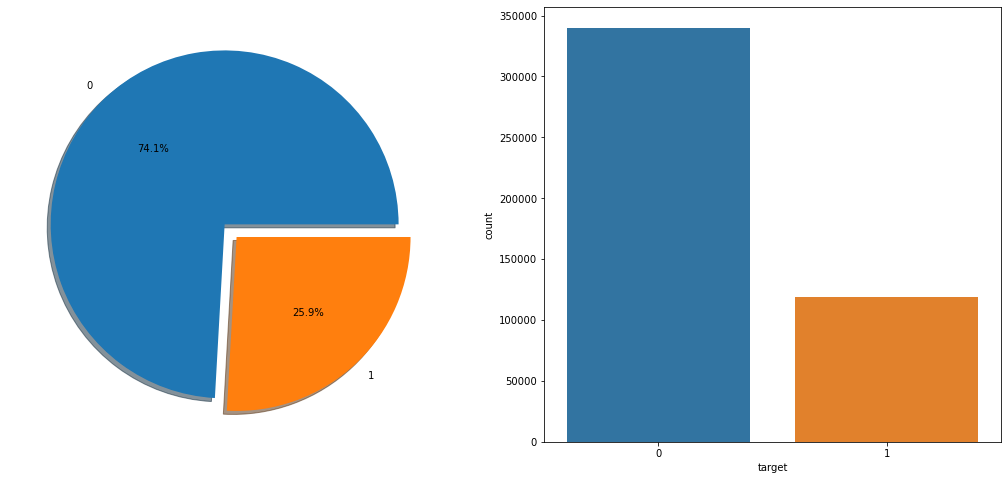

In [124]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df2['target'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_ylabel('')
sns.countplot('target',data=df2,ax=ax[1])
plt.show()

## モデリング

In [125]:
# 説明変数、目的変数の設定
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

df2 = df2.drop('customer_ID', axis=1)

X = df2.iloc[:len(df2), :-1].values
y = df2.iloc[:len(df2), -1].values
# X_test = df.iloc[len(df_train):, 1:].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [126]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import re
df2 = df2.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)) # 変なエラー解決するため入れた

# 学習に使用するデータを設定
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train) 

# パラメータ
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary', # 目的 : 分類
        'metric': {'auc'}, # 評価指標かな？
        'num_leaves': 20,             
        'max_depth':5,
        'min_data_in_leaf': 3,        
        'num_iteration': 100,            
        'learning_rate':0.03,
        'num_boost_round':100,
        'early_stopping_rounds':20, 
}

# モデルの学習
model = lgb.train(params,
                  train_set=lgb_train, # トレーニングデータの指定
                  valid_sets=lgb_eval, # 検証データの指定
                  )

# テストデータの予測
y_pred = model.predict(X_valid)

[LightGBM] [Info] Number of positive: 83180, number of negative: 238059
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46645
[LightGBM] [Info] Number of data points in the train set: 321239, number of used features: 196
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258935 -> initscore=-1.051512
[LightGBM] [Info] Start training from score -1.051512
[1]	valid_0's auc: 0.909625
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.913391
[3]	valid_0's auc: 0.915223
[4]	valid_0's auc: 0.916394
[5]	valid_0's auc: 0.917593
[6]	valid_0's auc: 0.918058
[7]	valid_0's auc: 0.918628
[8]	valid_0's auc: 0.923846
[9]	valid_0's auc: 0.924271
[10]	valid_0's auc: 0.925064
[11]	valid_0's auc: 0.925788
[12]	valid_0's auc: 0.926066
[13]	valid_0's auc: 0.926572
[14]	valid_0's auc: 0.926821
[15]	valid_0's auc: 0.927145
[16]	valid_0

(array([73782.,  9189.,  6514.,  5942.,  6181.,  6459.,  7296.,  7920.,
         8255.,  6136.]),
 array([0.01808046, 0.10981867, 0.20155688, 0.29329509, 0.38503331,
        0.47677152, 0.56850973, 0.66024794, 0.75198615, 0.84372436,
        0.93546257]),
 <BarContainer object of 10 artists>)

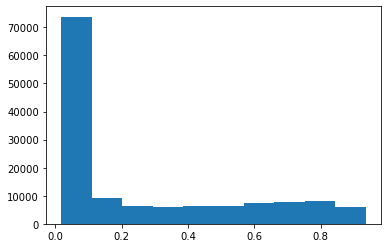

In [127]:
# 正解率？
plt.hist(y_pred)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

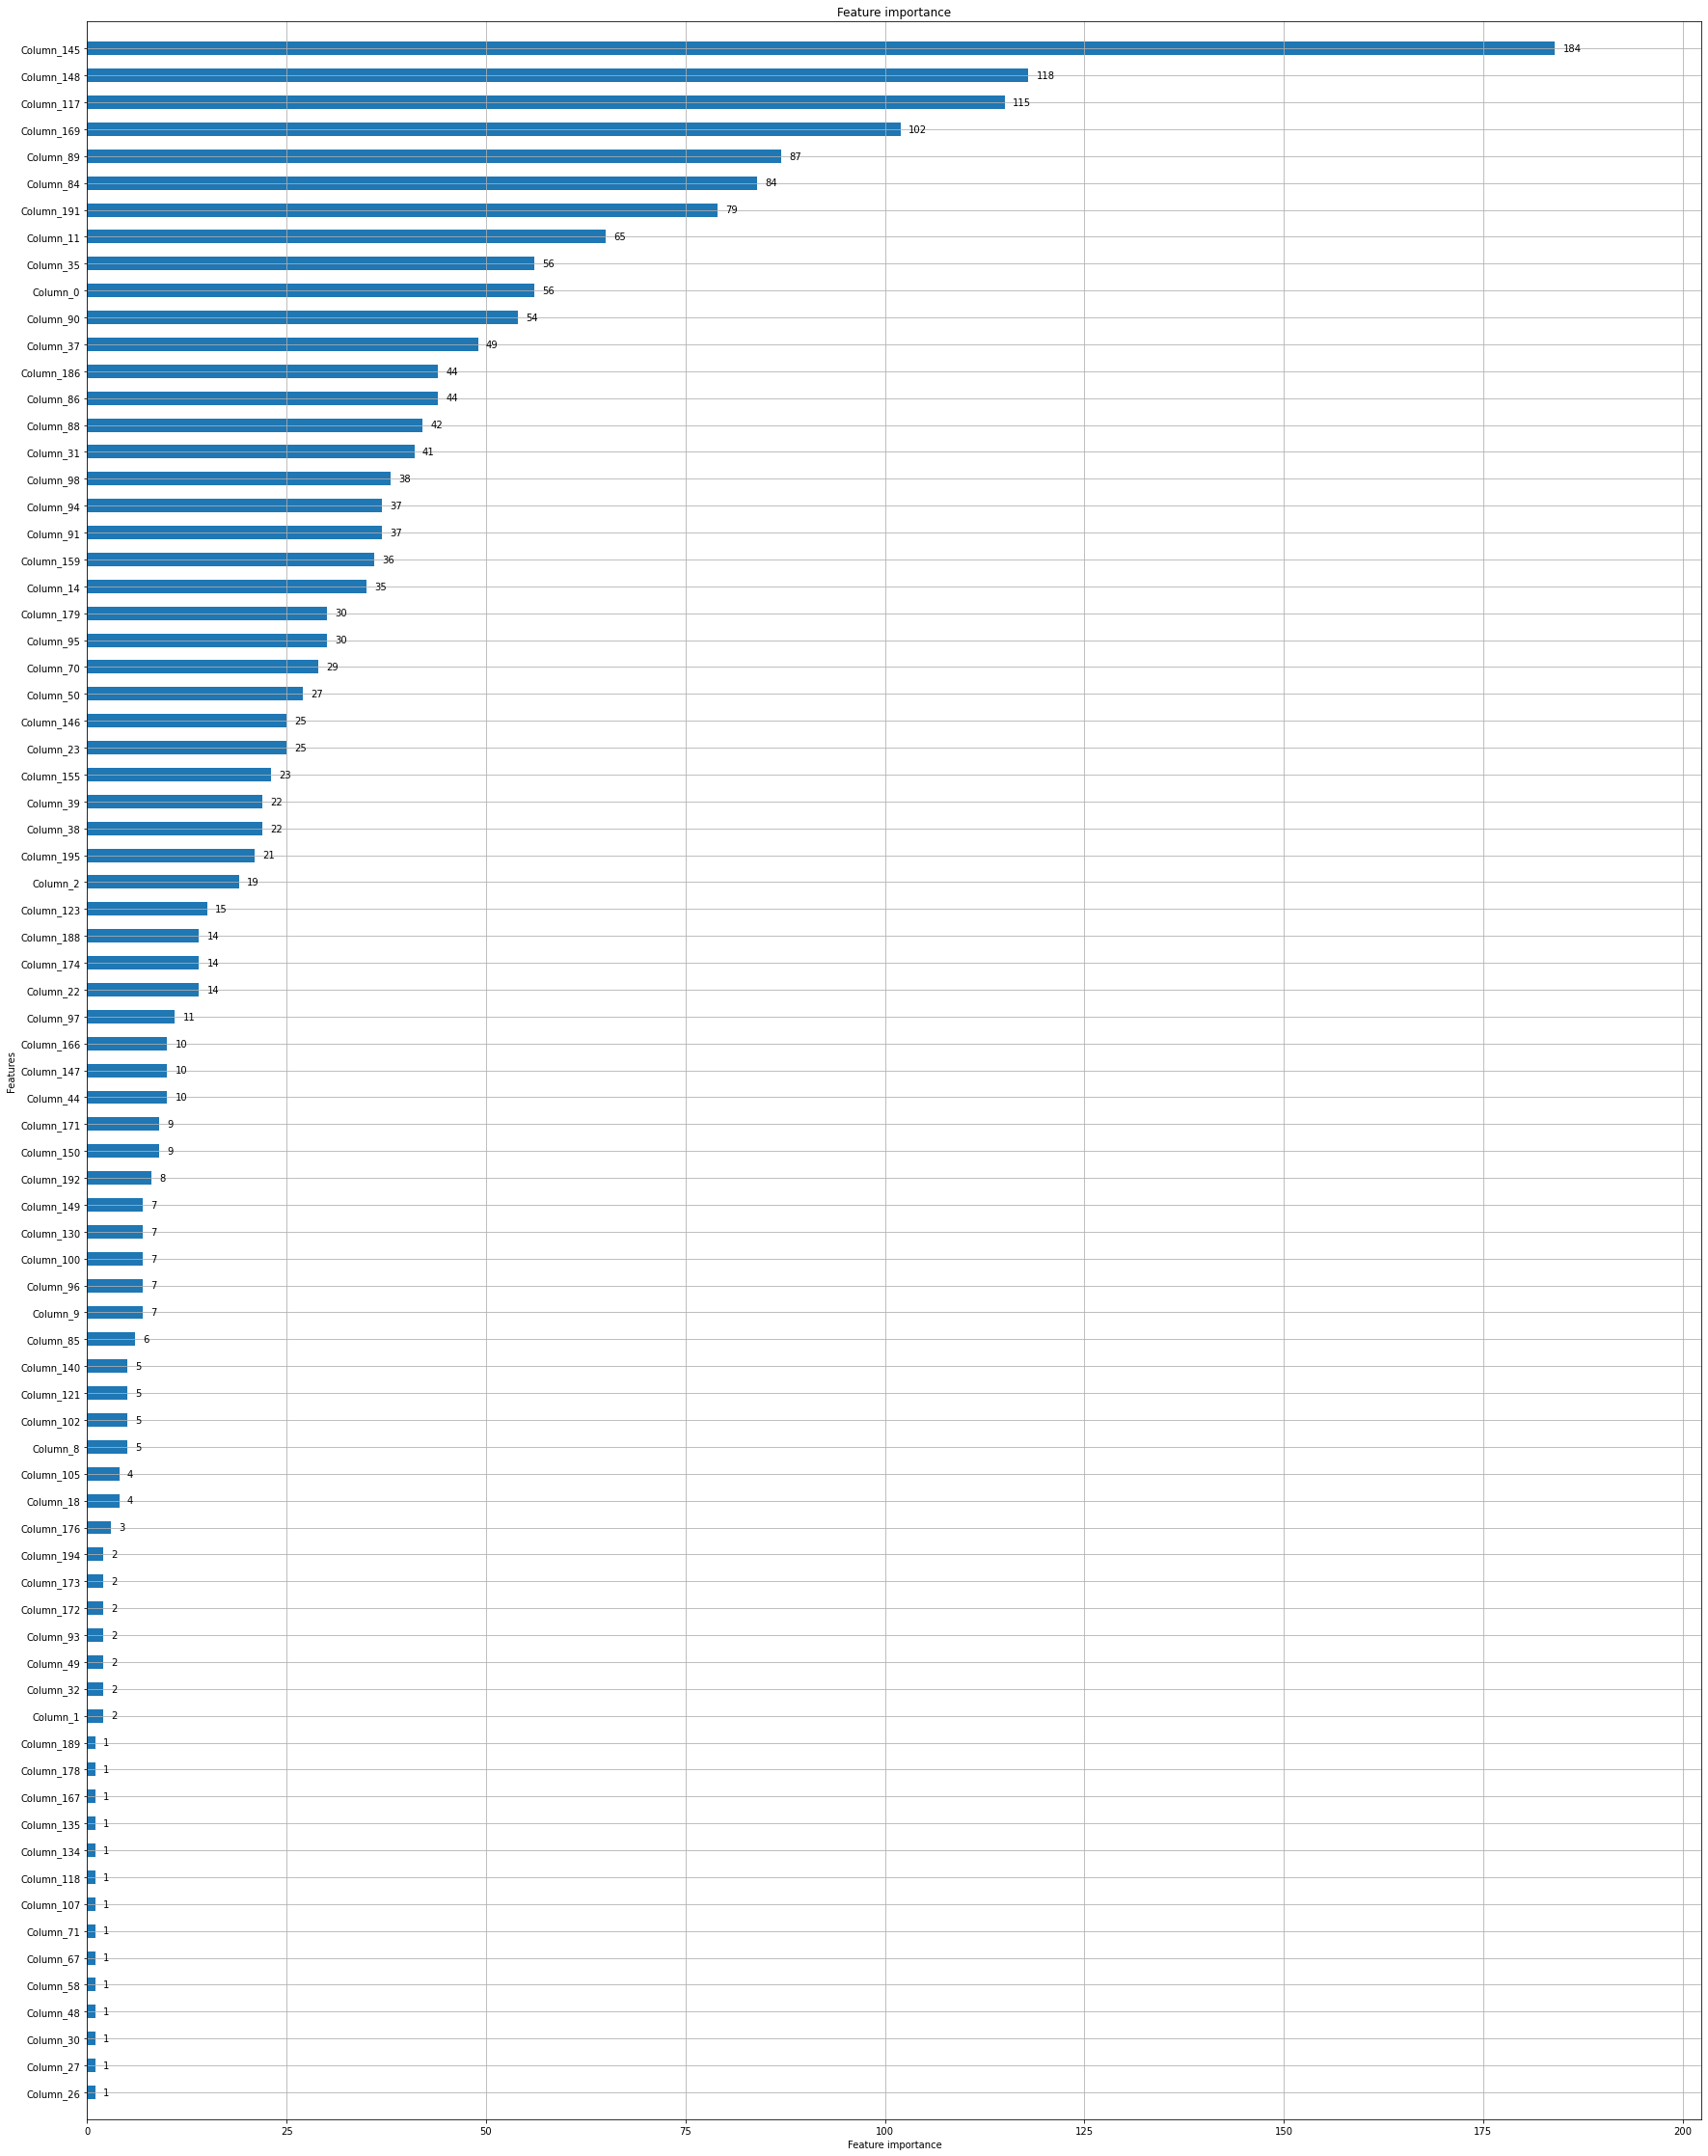

In [128]:
lgb.plot_importance(model, height=0.5, figsize=(30,40))
# なんで列名でないの

In [129]:
# LGBMClassifier
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(random_state=0)
lgb.fit(X_train, y_train)
lgb_train_pred = lgb.predict_proba(X_train)[:, 1]
lgb_valid_pred = lgb.predict_proba(X_valid)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, lgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, lgb_valid_pred)}")

# XGBClassifier
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=0)
xgb.fit(X_train, y_train)
xgb_train_pred = xgb.predict_proba(X_train)[:, 1]
xgb_valid_pred = xgb.predict_proba(X_valid)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, xgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, xgb_valid_pred)}")

# アンサンブル
train_pred = (lgb_train_pred + xgb_train_pred)/2
valid_pred = (lgb_valid_pred + xgb_valid_pred)/2

print(f"Train Score: {roc_auc_score(y_train, train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, valid_pred)}")

Train Score: 0.9563539069588445
Valid Score: 0.9529990926248918
Train Score: 0.9697280683249107
Valid Score: 0.9523647200634798
Train Score: 0.9648766341563948
Valid Score: 0.953860120210056


137674


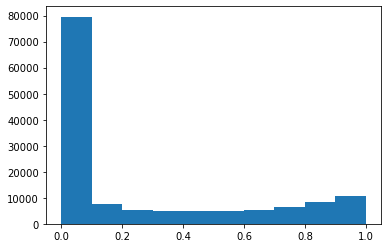

In [130]:
# 正解率の分布？
plt.hist(valid_pred)
print(len(valid_pred))

正解率： 0.8921510234321658 　閾値： 50


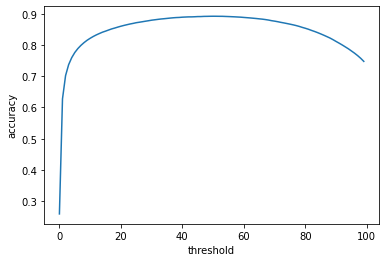

In [131]:
# 正解率と閾値の算出(valid_pred)

from sklearn.metrics import accuracy_score

lis_acc = []
for j in range(100):
    pred_acc = []
    for i in range(len(valid_pred)):
        if valid_pred[i]>=j/100:
            pred_acc.append(1)
        else:
            pred_acc.append(0)
    lis_acc.append(accuracy_score(y_valid, pred_acc))
    # print(j, accuracy_score(y_valid, pred_acc))
    
print('正解率：', max(lis_acc), '　閾値：', lis_acc.index(max(lis_acc)))
    
plt.xlabel("threshold")
plt.ylabel("accuracy")
plt.plot(lis_acc)
plt.show()

# 不均衡データだからこんなんになるのか
# testデータには D_64 = -1 のデータがないので落とす　-> 0.5%くらい精度落ちた…

正解率 0.8807327454711855 　閾値： 49


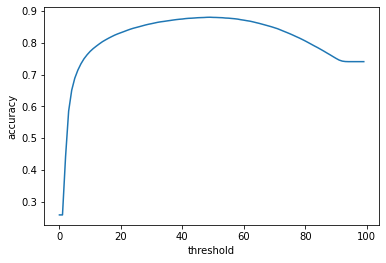

In [132]:
# 正解率と閾値の算出(y_pred = model.predict(X_valid))

lis_acc = []
for j in range(100):
    pred_acc = []
    for i in range(len(y_pred)):
        if y_pred[i]>=j/100:
            pred_acc.append(1)
        else:
            pred_acc.append(0)
    lis_acc.append(accuracy_score(y_valid, pred_acc))
    # print(j, accuracy_score(y_valid, pred_acc))
    
print('正解率', max(lis_acc), '　閾値：', lis_acc.index(max(lis_acc)))
    
plt.xlabel("threshold")
plt.ylabel("accuracy")
plt.plot(lis_acc)
plt.show()

# 上との違いなに...違う方法だけどどっちも正解率？

In [237]:
# df = pd.merge(df_train, df_train_labels, on='customer_ID', how='left')

# テストデータで予測モデル作成

In [63]:
test_grouped

,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,B_19,B_2,B_20,B_21,B_22,B_23,B_24,B_25,B_26,B_27,B_28,B_29,B_3,B_30,B_31,B_32,B_33,B_36,B_37,B_38,B_39,B_4,B_40,B_41,B_42,B_5,B_6,B_7,B_8,B_9,D_102,D_103,D_104,D_105,D_106,D_107,D_108,D_109,D_110,D_111,D_112,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,D_130,D_131,D_132,D_133,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,D_50,D_51,D_52,D_53,D_54,D_55,D_56,D_58,D_59,D_60,D_61,D_62,D_63_CL,D_63_CO,D_63_CR,D_63_XL,D_63_XM,D_63_XZ,D_63_nan,D_64_O,D_64_R,D_64_U,D_64_nan,D_65,D_66,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_78,D_79,D_80,D_81,D_82,D_83,D_84,D_86,D_87,D_88,D_89,D_91,D_92,D_93,D_94,D_96,P_2,P_3,P_4,R_1,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_2,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_3,R_4,R_5,R_6,R_7,R_8,R_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_20,S_22,S_23,S_24,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9
customer_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,0.013925,0.037069,0.006187,0.082867,11.048183,0.018828,0.020536,0.003792,99.000000,0.590665,0.004468,0.898289,0.005869,0.007769,0.004888,0.254266,0.005203,0.004567,0.005206,0.005720,0.145220,44.002163,0.009732,0.000000,1.0,0.005471,1.005949,0.004009,0.013483,1.777778,99.0,0.132557,0.368253,0.006821,99.0,0.047263,0.218059,0.283370,1.006641,0.003733,0.005494,11.003713,11.005265,99.000000,99.000000,11.002491,99.000000,0.004123,99.0,99.0,1.004091,44.003166,44.0,44.140057,44.0,43.444444,44.137173,44.137592,44.555556,44.109306,44.080723,44.002071,44.004681,44.003151,0.000000,0.005166,11.005355,11.005939,11.004889,11.004107,99.000000,0.004254,99.0,99.0,99.0,99.0,99.0,11.003985,0.003996,11.005029,99.000000,11.004870,0.005730,11.004685,0.069758,0.002635,0.118016,77.001518,0.007083,0.011955,44.247833,0.479550,0.578279,99.000000,99.000000,0.041620,0.117639,99.000000,1.005194,0.317071,99.000000,0.377217,22.320761,0.042616,0.597552,0.035462,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.555556,0.444444,0.004591,99.0,47.333333,44.003464,11.003924,0.072740,0.004783,0.182713,0.219199,0.204130,99.0,88.000320,0.004126,11.004030,0.005002,0.004031,0.504131,44.002857,0.004711,0.007949,99.0,99.0,0.004934,77.000511,0.116208,0.004286,0.005423,0.004607,0.601387,44.328854,0.961646,0.005773,0.005161,0.005572,1.004421,0.004435,0.004547,0.003600,0.004303,0.004437,0.003736,0.003948,0.005000,0.004758,0.003851,0.004632,0.005964,0.006416,0.005308,99.000000,11.894776,0.005292,0.104659,0.005101,0.004464,0.003876,0.004423,0.006230,99.000000,1.608184,0.136646,0.601419,0.459957,0.005912,0.005725,0.006010,0.006266,0.005406,0.962658,0.136015,0.949735,0.973917,0.038056,0.299671,0.188640,0.006742,0.227071,0.170330,0.271142,11.013840
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,0.052342,0.298050,0.035716,0.043231,0.099541,0.034238,0.004710,0.051158,99.000000,1.005336,0.004885,1.003704,0.004922,0.006818,0.004317,0.022771,0.005254,0.058109,0.002775,0.005269,0.033780,99.000000,0.006160,0.000000,1.0,0.003917,1.003672,0.005196,0.049217,2.230769,99.0,0.061213,0.025251,0.005565,99.0,0.101462,0.195901,0.033406,1.004206,0.081637,0.004841,0.003439,0.005631,99.000000,99.000000,0.004473,99.000000,0.005269,99.0,99.0,1.005064,0.003922,1.0,0.309216,0.0,3.000000,0.303904,0.303837,0.000000,0.842254,0.576952,0.003205,0.641199,0.004250,1.000000,0.006148,1.003930,0.004997,0.005076,0.004196,99.000000,0.004032,99.0,99.0,99.0,99.0,99.0,0.006455,0.004865,0.004814,99.000000,0.005762,0.005329,0.005466,0.154252,0.003970,99.000000,99.000000,0.004452,0.088032,0.454435,0.351355,0.070145,99.000000,99.000000,0.158422,0.148449,99.000000,1.004121,0.063459,15.285120,0.005272,0.583729,0.507825,0.0700

In [65]:
submission = pd.read_csv(path + 'sample_submission.csv')

In [133]:
# テストデータに対する予測値の作成
X_test = test_grouped.values

# pred = lgb.predict_proba(X_test)[:, 1]
pred_test = (lgb.predict_proba(X_test)[:, 1] + xgb.predict_proba(X_test)[:, 1]) / 2

(array([538646.,  53879.,  37275.,  32611.,  31509.,  32943.,  36062.,
         41812.,  50934.,  68950.]),
 array([4.51663183e-04, 1.00260789e-01, 2.00069914e-01, 2.99879039e-01,
        3.99688165e-01, 4.99497290e-01, 5.99306415e-01, 6.99115541e-01,
        7.98924666e-01, 8.98733791e-01, 9.98542917e-01]),
 <BarContainer object of 10 artists>)

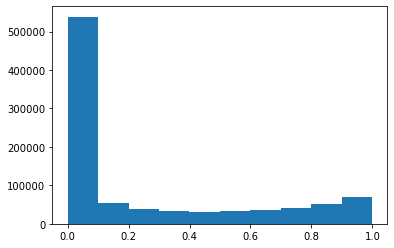

In [134]:
# 確率分布　トレーニングデータと同じ形状になった
plt.hist(pred_test)

In [135]:
# 閾値を0.5としてバイナリーに変換してみる（提出は確率）

pred_test_bi = []
for i in pred_test:
    if i > 0.5:
        pred_test_bi.append(1)
    else:
        pred_test_bi.append(0)

In [136]:
# 正例の予測割合
sum(pred_test_bi) / len(pred_test_bi)

0.24932377698538102

In [ ]:
# 予測結果を提出用のフォーマットに格納
submission['prediction'] = np.array(pred_test)

# 提出用のcsvファイルを作成
submission.to_csv('C:/Users/Victor/Documents/my_study/Kaggle/Amex-Default-Prediction/submission.csv', index=False)
submission

# 0.750

# メモリ確認

In [2]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_"):
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                       In|        96|
|                      Out|       232|
|                     exit|        48|
|              get_ipython|        64|
|                     quit|        48|
|                      sys|        72|
|                 var_name|        57|
